# Jupyter Notebook for Task 4: Modeling



## Preperation
Before we start modeling, we have to load the packages and the data, and prepare it so it can be processed by the models.

In [ ]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.core.interchange.dataframe_protocol import DataFrame

#polynomial regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# import custom functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# supress versioning warnings of keras
import warnings

from tensorflow.python.keras.regularizers import l1_l2

warnings.filterwarnings('ignore')

%matplotlib inline

import os
os.environ["KERAS_BACKEND"] = "torch"

In [263]:
import keras
from keras import Sequential # sequential model: https://keras.io/guides/sequential_model/
from keras.layers import Dense, Dropout, BatchNormalization


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29717 entries, 2018-04-25 04:00:00-07:00 to 2021-09-14 08:00:00-07:00
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   activeSessions_site2     29717 non-null  int64  
 1   utilizationRate_site2    29717 non-null  float64
 2   kWhDelivered_site2       29717 non-null  float64
 3   idleRate_site2           29717 non-null  float64
 4   blockedRate_site2        29717 non-null  float64
 5   activeSessions_site1     29717 non-null  int64  
 6   utilizationRate_site1    29717 non-null  float64
 7   kWhDelivered_site1       29717 non-null  float64
 8   idleRate_site1           29717 non-null  float64
 9   blockedRate_site1        29717 non-null  float64
 10  activeSessions_total     29717 non-null  int64  
 11  kWhDelivered_total       29717 non-null  float64
 12  utilizationRate_total    29717 non-null  float64
 13  idleRate_total           2971

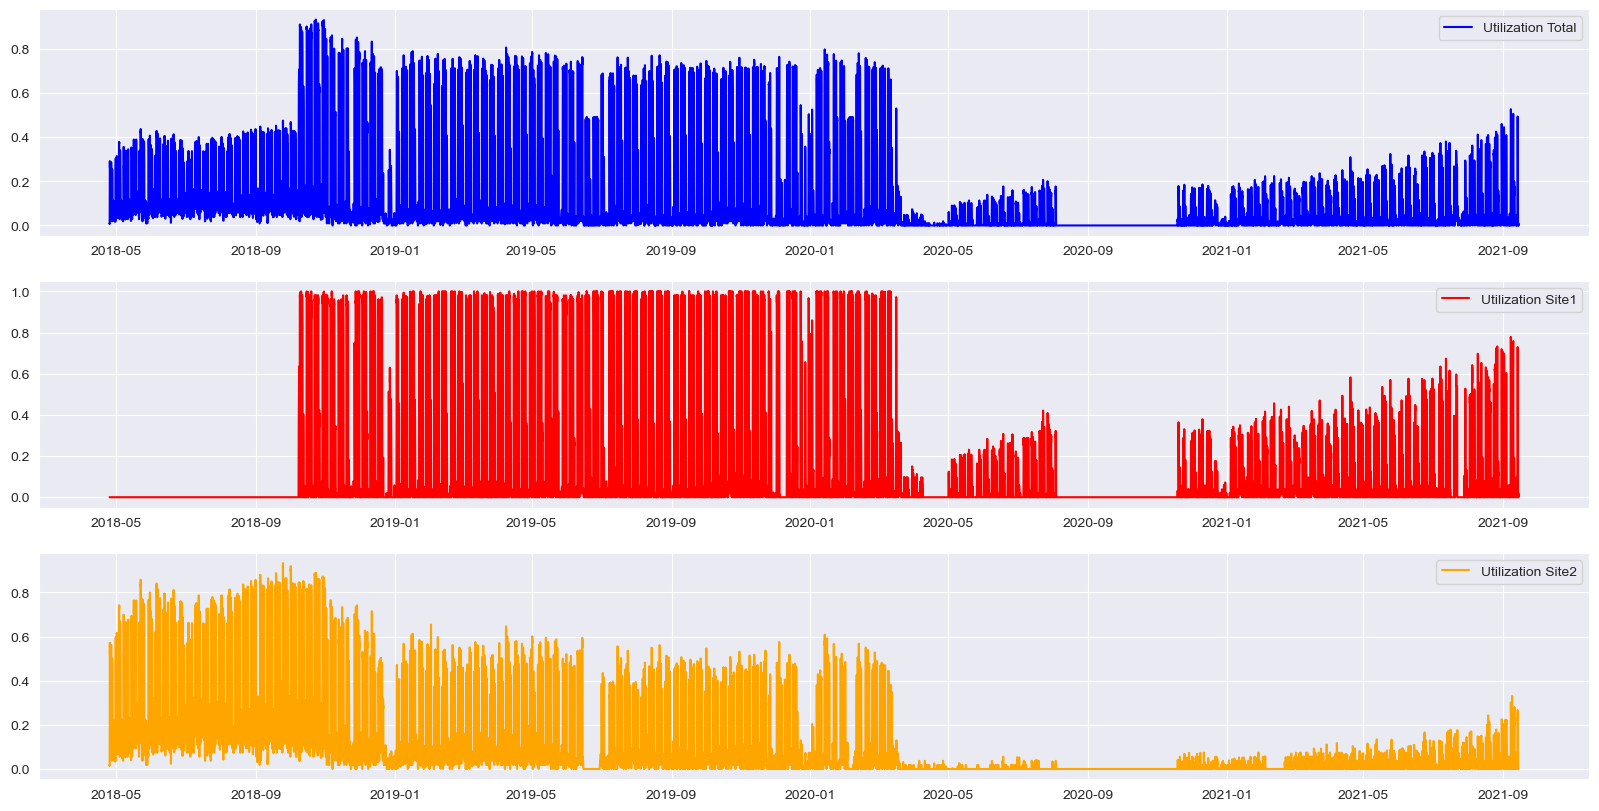

In [264]:
agg_charging_data = pd.read_pickle(os.path.join('Data', 'aggregated_data.pkl'))
agg_charging_data['year'] = agg_charging_data.index.year

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_total'], label='Utilization Total', color='blue')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_site1'], label='Utilization Site1', color='red')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_site2'], label='Utilization Site2', color='orange')
plt.legend()

agg_charging_data.info(20)

If we plot the utilization over time, we can observe some interesting pattern. The Strong dip at around 03/2020 can be explained with the corona pandamic. Besides there is a time frame with no values. The objective for this task (based on the Data mining goal) is to predict the untilization of the sites for a short term after the data ends (10/2021). This is why training the models  on these extraordinary events is not feasable, which is why we are onlyusing the data frm after the data hole.

In [265]:
agg_charging_data = agg_charging_data[agg_charging_data['year'] == 2021]
agg_charging_data['week_of_year'] = agg_charging_data['week_of_year'].astype('int32')

Define the model properties:

1. Input features: hour_of_day, day_of_week, month_of_year, year
    - Why these features: We cannot use real-time or future-dependent inputs unless they are forecasted or modeled beforehand. That is why we can obly deterministic values for our prediction.
2. Target features: utilizationRate_siteX
3. Model parameters: Coefficients (θ) for polynomial regression or weights (𝑊,𝑏) for neural network.
4. Hypothesis function: Polynomial regression: 𝑦^=ℎ𝜃(𝑋), Neural network: y^=f(W,b).
5. Objective funktion: Mean Squared Error (MSE): J(θ)=1/m*∑(y^−y)^2.

In [266]:
#different data sets to train the models
gesamt_charging_data = agg_charging_data[['utilizationRate_total', 'hour_of_day', 'day_of_week', 'year', 'month_of_year']]

site1_charging_data = agg_charging_data[
    ['utilizationRate_site1', 'hour_of_day', 'day_of_week', 'year', 'month_of_year']]

site2_charging_data = agg_charging_data[
    ['utilizationRate_site2', 'hour_of_day', 'day_of_week', 'year', 'month_of_year']]

## Neural Network

In [267]:
from sklearn.preprocessing import MinMaxScaler

# Is weekend hinzufügen
# Daten aufteilen
X = gesamt_charging_data[['hour_of_day', 'day_of_week', 'month_of_year', 'year']]
y = gesamt_charging_data['utilizationRate_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) #shuffle = False ensures to split the data in order

# Daten skalieren
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [268]:
# Modell erstellen
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)  # Für die Vorhersage eines kontinuierlichen Wertes
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Modell trainieren
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - mae: 0.0708 - val_loss: 0.0115 - val_mae: 0.0911
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mae: 0.0388 - val_loss: 0.0087 - val_mae: 0.0768
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - mae: 0.0410 - val_loss: 0.0073 - val_mae: 0.0680
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - mae: 0.0368 - val_loss: 0.0066 - val_mae: 0.0631
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - mae: 0.0321 - val_loss: 0.0062 - val_mae: 0.0595
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - mae: 0.0288 - val_loss: 0.0059 - val_mae: 0.0568
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - mae: 0.0272 - val_loss: 0.0057 - val_mae: 0.0549
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 0.0056 - val_mae: 0.0534
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - lo

In [269]:
#check the overview of the training and validation loss 
history_df = pd.DataFrame(history.history)
history_df

,loss,mae,val_loss,val_mae
0,0.005986,0.056447,0.011455,0.091134
1,0.002364,0.035578,0.008653,0.076841
2,0.002216,0.033424,0.007341,0.068039
3,0.001878,0.030533,0.006614,0.063079
4,0.001590,0.028205,0.006173,0.059488
5,0.001435,0.026819,0.005905,0.056822
6,0.001350,0.025909,0.005727,0.054898
7,0.001284,0.025134,0.005622,0.053427
8,0.001231,0.024415,0.005540,0.052371
9,0.001188,0.023799,0.005489,0.051630


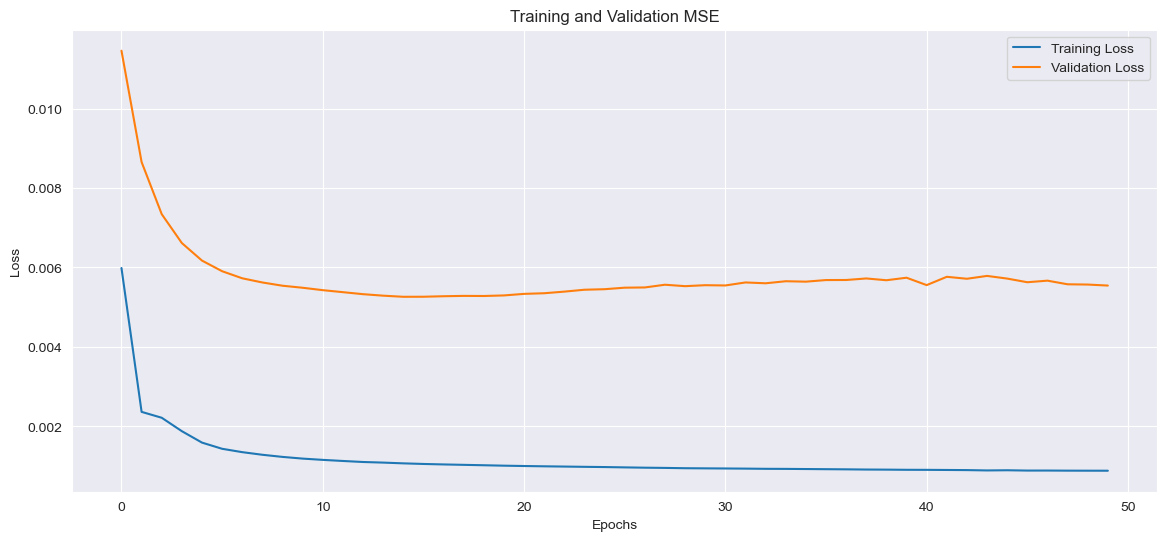

In [270]:
# Plot training and validation loss to see the differences in each epoch
plt.figure(figsize=(14, 6))

plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation MSE')

plt.show()

In [271]:
# Vorhersagen
y_pred_nn = model.predict(X_test)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [272]:
#Measure performance
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}, R²: {r2_nn}")

Neural Network - MSE: 0.007339081467088546, MAE: 0.05866702698698176, R²: 0.6385509745954453


In [279]:
# Modell erstellen
model_retrain = Sequential([
    Dense(32, activation='relu',  input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)  # Für die Vorhersage eines kontinuierlichen Wertes
])

model_retrain.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Modell trainieren
history = model_retrain.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0285 - mae: 0.1156 - val_loss: 0.0075 - val_mae: 0.0679
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0632 - val_loss: 0.0066 - val_mae: 0.0626
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - mae: 0.0535 - val_loss: 0.0067 - val_mae: 0.0637
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - mae: 0.0418 - val_loss: 0.0069 - val_mae: 0.0642
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - mae: 0.0343 - val_loss: 0.0070 - val_mae: 0.0640


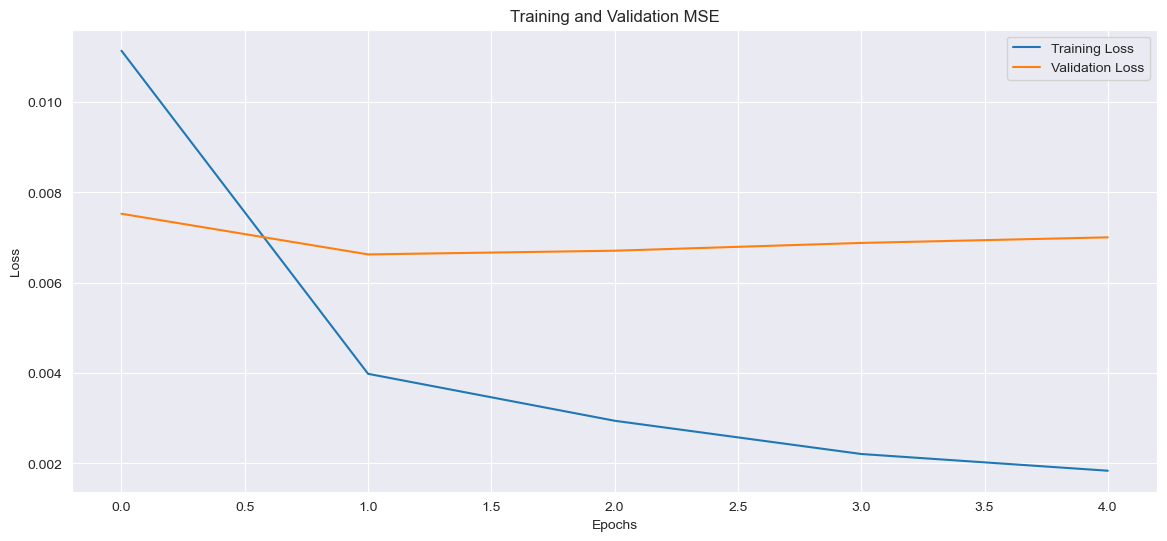

In [280]:
#check the overview of the training and validation loss 
history_df = pd.DataFrame(history.history)

# Plot training and validation loss to see the differences in each epoch
plt.figure(figsize=(14, 6))

plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation MSE')

plt.show()

In [281]:
# Vorhersagen
y_pred_nn = model_retrain.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [282]:
#Measure performance
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}, R²: {r2_nn}")

Neural Network - MSE: 0.011164242585556336, MAE: 0.08222343902515014, R²: 0.4501621735600938


## Polynomial regression

First, lets prepare the training and data set. To find the right degree, we train the model on a rage from 1 to 20.

In [ ]:
# Prepare data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X, y, test_size=0.1, shuffle=False)

# Initialize lists to store results
degrees = range(1, 10)  # Test polynomial degrees from 1 to 9
train_mse = []
validation_mse = []

# Loop over different polynomial degrees
for d in degrees:
    # Create a pipeline for the current degree
    pipeline = Pipeline([
        ('polynomial_features', PolynomialFeatures(degree=d)),
        ('scaler', StandardScaler()),
        ('ridge_regression', Ridge(alpha=0.0))  # First try without regularization
    ])
    
    # Fit the pipeline on training data
    pipeline.fit(X_train_poly, y_train_poly)
    
    # Calculate MSE on training data
    y_train_pred = pipeline.predict(X_train_poly)
    train_mse.append(mean_squared_error(y_train_poly, y_train_pred))
    
    # Calculate MSE on validation data
    y_test_pred = pipeline.predict(X_test_poly)
    validation_mse.append(mean_squared_error(y_test_poly, y_test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mse, label="Training MSE", marker='o')
plt.plot(degrees, validation_mse, label="Validation MSE", marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error")
plt.ylim(0, 0.05)
plt.title("Training and Validation MSE vs Polynomial Degree")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Range of alpha values to test (logarithmic scale)
alphas = np.logspace(-4, 2, 20)  # From 0.0001 to 100
train_mse_alpha = []
validation_mse_alpha = []

# Loop over different alpha values
for alpha in alphas:
    # Create a pipeline with fixed degree and current alpha
    pipeline = Pipeline([
        ('polynomial_features', PolynomialFeatures(degree=6)),
        ('scaler', StandardScaler()),
        ('ridge_regression', Ridge(alpha=alpha))
    ])
    
    # Fit the pipeline on training data
    pipeline.fit(X_train_poly, y_train_poly)
    
    # Calculate MSE on training data
    y_train_pred = pipeline.predict(X_train_poly)
    train_mse_alpha.append(mean_squared_error(y_train_poly, y_train_pred))
    
    # Calculate MSE on validation data
    y_test_pred = pipeline.predict(X_test_poly)
    validation_mse_alpha.append(mean_squared_error(y_test_poly, y_test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_mse_alpha, label="Training MSE", marker='o')
plt.plot(alphas, validation_mse_alpha, label="Validation MSE", marker='o')
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title(f"Training and Validation MSE vs Alpha (Degree={6})")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create a pipeline with PolynomialFeatures, scaling, and Ridge regression
D = 6
ALPHA = 0.02

pipeline = Pipeline([
    ('polynomial_features', PolynomialFeatures(degree=D)),  # Polynomial features of degree 6
    ('scaler', StandardScaler()),                          # Standardize features for regularization
    ('ridge_regression', Ridge(alpha=ALPHA))                 # Ridge regression with L2 regularization
])

# Fit the pipeline on the training data
pipeline.fit(X_train_poly, y_train_poly)

# Predict using the pipeline
y_pred_poly = pipeline.predict(X_test_poly)

# Calculate mean squared error
mse = mean_squared_error(y_test_poly, y_pred_poly)
print(f"Mean Squared Error (Polynomial Regression with Ridge Regularization): {mse}")

In [ ]:
# Neuronales Netzwerk
# Vorhersagen

mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)


# Polynome Regression
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)


import matplotlib.pyplot as plt
import numpy as np

# Index erstellen, um die Testdaten in der Reihenfolge darzustellen
indices = np.arange(len(y_test_poly))

plt.figure(figsize=(12, 6))

# Tatsächliche Werte plotten
plt.plot(indices, y_test, label='Actual Values', color='blue', linestyle='-', alpha=0.7)

#replace negative values with null 
y_pred_nn = np.maximum(0, y_pred_nn)
# Vorhergesagte Werte plotten
plt.plot(indices, y_pred_poly, label='Predicted Values Polynominal regression', color='orange', linestyle='-', alpha=0.7)
plt.plot(indices, y_pred_nn, label='Predicted Values Neural Network', color='red', linestyle='-', alpha=0.7)

# Titel und Achsenbeschriftungen
plt.title("Actual vs. Predicted Values (Test Set)", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Utilization Rate", fontsize=12)

# Legende und Gitter
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Plot anzeigen
plt.show()
print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}, R²: {r2_nn}")
print(f"Polynomial Regression - MSE: {mse_poly}, MAE: {mae_poly}, R²: {r2_poly}")


The comparison indicates a better performance of the polynominal regression, likely because of the limited complexity. Lets use the model to predict the next weeks utilization.

In [ ]:
# Convert X_test back to a DataFrame if it's a NumPy array
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=['hour_of_day', 'day_of_week', 'month_of_year', 'year'])

# Extend the test set one month forward
def extend_test_set(X_test, n_steps=24):
    extended_test_set = pd.DataFrame()  # Initialize an empty DataFrame
    last_row = X_test.iloc[-1].copy()  # Start from the last row
    extended_rows = []
    for _ in range(n_steps):  # Simulate the next 'n_steps' rows
        last_row['hour_of_day'] += 1
        if last_row['hour_of_day'] > 24:  # Reset hour_of_day and increment day_of_week
            last_row['hour_of_day'] = 1
            last_row['day_of_week'] += 1
        if last_row['day_of_week'] > 7:  # Reset day_of_week and increment month_of_year
            last_row['day_of_week'] = 1
            last_row['month_of_year'] += 1
        if last_row['month_of_year'] > 12:  # Reset month_of_year and increment year
            last_row['month_of_year'] = 1
            last_row['year'] += 1
        extended_rows.append(last_row.copy())  # Add the new row
    
    extended_test_set = pd.concat([extended_test_set, pd.DataFrame(extended_rows)], ignore_index=True)
    return extended_test_set

# Generate extended test set
X_test_extended = extend_test_set(X_test, n_steps=300)

# Predict on the extended test set
y_extended_pred = model.predict(X_test_extended)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Test Set', color='blue')
plt.plot(range(len(y_test), len(y_test) + len(y_extended_pred)), y_extended_pred, label='Next Weeks Predictions', color='orange')
plt.xlabel("Time Steps")
plt.ylabel("Utilization Rate")
plt.title("Test Set and Extended Predictions")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
S# Final data for the models


In [ ]:
def train_and_evaluate(model, visualize=False):
    history = model.fit(X_train, y_train, batch_size = 20, epochs = 20, validation_split=0.4)
    if visualize:
        pd.DataFrame(history.history).plot()

train_and_evaluate(model, visualize=True)